In [3]:
# Part 6 — Company 2 (MIP in *millions* with per-medium minimum spend)
import math
import pandas as pd
from gurobipy import Model, GRB, quicksum

# ---------------- CONFIG (all amounts are IN MILLIONS) ----------------
ROI_FILE = "roi_company2.csv"
MIN_FILE = "min_amount.csv"

BUDGET_M = 10.0           # 10M total budget
CAP_PER_PLATFORM_M = 3.0  # 3M per platform cap

PRINT = "Print"; TV = "TV"; FACEBOOK = "Facebook"; EMAIL = "Email"
SOCIAL = ["Facebook", "LinkedIn", "Instagram", "Snapchat", "Twitter"]
SEARCH = ["SEO", "AdWords"]
# ---------------------------------------------------------------------

def load_roi_in_millions(path):
    """Return columns: platform, tier_idx, lower_m, upper_m, width_m, roi (decimal)."""
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    syn = {
        "channel":"platform", "medium":"platform",
        "roi":"roi_pct", "roi%":"roi_pct", "return":"roi_pct",
        "tier":"tier", "lower":"tier_lower", "lowerbound":"tier_lower",
        "upper":"tier_upper", "upperbound":"tier_upper",
    }
    df = df.rename(columns={c: syn.get(c, c) for c in df.columns})
    req = {"platform","tier_lower","tier_upper","roi_pct"}
    miss = req - set(df.columns)
    if miss:
        raise ValueError(f"{path} missing {miss}. Found: {list(df.columns)}")

    for c in ["tier_lower","tier_upper","roi_pct"]:
        df[c] = pd.to_numeric(df[c], errors="raise")

    # ROI % -> decimal
    if df["roi_pct"].dropna().mean() > 1.0:
        df["roi_pct"] = df["roi_pct"] / 100.0

    # Bound units -> millions if looks like dollars
    if df["tier_upper"].dropna().max() > 50:
        df["tier_lower"] = df["tier_lower"] / 1_000_000.0
        df["tier_upper"] = df["tier_upper"] / 1_000_000.0

    df["tier_upper"] = df["tier_upper"].fillna(float("inf"))
    df = df.sort_values(["platform","tier_lower","tier_upper"]).reset_index(drop=True)
    df["tier_idx"] = df.groupby("platform").cumcount() + 1

    widths = []
    for lo, up in zip(df["tier_lower"], df["tier_upper"]):
        if math.isfinite(up):
            widths.append(max(0.0, float(up - lo)))
        else:
            widths.append(CAP_PER_PLATFORM_M)  # enough to reach the cap
    df["width_m"] = widths

    return df[["platform","tier_idx","tier_lower","tier_upper","width_m","roi_pct"]].rename(
        columns={"tier_lower":"lower_m", "tier_upper":"upper_m", "roi_pct":"roi"}
    )

def load_min_in_millions(path):
    """
    Expects columns like: platform, min_amount (or min / minimum)
    Returns dict: platform -> min_m (millions).
    """
    df = pd.read_csv(path)
    df.columns = [c.strip().lower() for c in df.columns]
    # map likely column names
    rename = {"channel":"platform","medium":"platform",
              "min":"min_amount","minimum":"min_amount","min_spend":"min_amount"}
    df = df.rename(columns={c: rename.get(c,c) for c in df.columns})
    if "platform" not in df.columns:
        raise ValueError("min_amount.csv must include a 'platform' column.")
    # find min column
    min_col = None
    for cand in ["min_amount","minimum_amount","minimum","min"]:
        if cand in df.columns:
            min_col = cand; break
    if min_col is None:
        # fallback: assume the second column is the min
        min_col = [c for c in df.columns if c != "platform"][0]

    df[min_col] = pd.to_numeric(df[min_col], errors="raise")

    # Convert to millions if the values look like dollars
    if df[min_col].max() > 50:   # heuristic: probably dollars
        df[min_col] = df[min_col] / 1_000_000.0

    out = dict(zip(df["platform"], df[min_col]))
    return out

roi = load_roi_in_millions(ROI_FILE)
min_map = load_min_in_millions(MIN_FILE)

# Sanity checks on minima
for p, v in list(min_map.items()):
    if v < 0:
        raise ValueError(f"Minimum for {p} is negative: {v}")
    if v > CAP_PER_PLATFORM_M + 1e-9:
        raise ValueError(f"Minimum for {p} ({v}M) exceeds per-platform cap {CAP_PER_PLATFORM_M}M.")

if sum(min_map.get(p, 0.0) for p in roi["platform"].unique()) > BUDGET_M + 1e-9:
    print("WARNING: Sum of minima exceeds total budget; problem may be infeasible.")

# Model sets
platforms = sorted(roi["platform"].unique())
tiers_by_p = {p: list(roi.loc[roi.platform==p, "tier_idx"]) for p in platforms}
width_by_p_t = {(r.platform, r.tier_idx): float(r.width_m) for r in roi.itertuples()}
roi_by_p_t   = {(r.platform, r.tier_idx): float(r.roi)     for r in roi.itertuples()}
min_by_p     = {p: float(min_map.get(p, 0.0)) for p in platforms}  # 0 if not specified

# --------------------------- Build the MIP ---------------------------
m = Model("company2_part6_minimums")
m.Params.OutputFlag = 0

# Tier spend x[p,t] (millions), tier on/off y[p,t], medium on/off z[p]
x, y, z = {}, {}, {}
for p in platforms:
    z[p] = m.addVar(vtype=GRB.BINARY, name=f"z[{p}]")
    for t in tiers_by_p[p]:
        x[p,t] = m.addVar(lb=0.0, ub=width_by_p_t[p,t], name=f"x[{p},{t}]")
        y[p,t] = m.addVar(vtype=GRB.BINARY, name=f"y[{p},{t}]")

# Budget: sum x = total budget
m.addConstr(quicksum(x[p,t] for p in platforms for t in tiers_by_p[p]) == BUDGET_M, name="budget")

# Per-platform cap (redundant with x upper bounds but keeps things clear)
for p in platforms:
    m.addConstr(quicksum(x[p,t] for t in tiers_by_p[p]) <= CAP_PER_PLATFORM_M * z[p], name=f"cap[{p}]")

# Link x to y (tier widths) and contiguity of tiers
for p in platforms:
    ts = tiers_by_p[p]
    for idx, t in enumerate(ts):
        m.addConstr(x[p,t] <= width_by_p_t[p,t] * y[p,t], name=f"link[{p},{t}]")
        if idx > 0:
            m.addConstr(y[p,t] <= y[p, ts[idx-1]], name=f"chain[{p},{t}]")

# NEW: minimum-spend if we invest in a platform
for p in platforms:
    min_m = min_by_p[p]
    if min_m > 0:
        # If z[p]=1 (invest), total spend on p must be at least min_m
        m.addConstr(quicksum(x[p,t] for t in tiers_by_p[p]) >= min_m * z[p], name=f"min[{p}]")
    else:
        # If min is 0, no extra constraint needed; z still switches the platform on/off.
        pass

# Convenience: platform totals (in millions)
def spend_p(p): 
    return quicksum(x[p,t] for t in tiers_by_p[p])

# Business rules (unchanged)
# 1) Print + TV <= Facebook + Email
m.addConstr(spend_p(PRINT) + spend_p(TV) <= spend_p(FACEBOOK) + spend_p(EMAIL),
            name="rule_print_tv_le_fb_email")

# 2) Social >= 2 * Search
social_set = [p for p in platforms if p in set(SOCIAL)]
search_set = [p for p in platforms if p in set(SEARCH)]
m.addConstr(quicksum(spend_p(p) for p in social_set) >= 2.0 * quicksum(spend_p(p) for p in search_set),
            name="rule_social_ge_2x_search")

# Objective: maximize Σ ROI[p,t] * x[p,t]  (units: *millions of dollars*)
m.setObjective(quicksum(roi_by_p_t[p,t] * x[p,t] for p in platforms for t in tiers_by_p[p]), GRB.MAXIMIZE)
m.optimize()

# --------------------------- Report ---------------------------
status_map = {
    GRB.OPTIMAL: "OPTIMAL",
    GRB.INFEASIBLE: "INFEASIBLE",
    GRB.TIME_LIMIT: "TIME_LIMIT",
    GRB.INTERRUPTED: "INTERRUPTED",
}
print("Solver status:", status_map.get(m.status, m.status))

if m.status == GRB.OPTIMAL:
    obj_millions = m.ObjVal
    print(f"\nI got an objective of {obj_millions:.6f} (millions of $).")
    for p in platforms:
        invested = sum(x[p,t].X for t in tiers_by_p[p])
        on_tiers = [t for t in tiers_by_p[p] if y[p,t].X > 0.5]
        is_on = int(z[p].X > 0.5)
        min_req = min_by_p[p]
        print(f"{p:10s}  invested={invested:0.3f}M   min={min_req:0.3f}M   on={is_on}   tiers_on={on_tiers}")
else:
    print("No optimal solution returned; please check feasibility (minima vs budget/caps/rules).")


Solver status: OPTIMAL

I got an objective of 0.495400 (millions of $).
AdWords     invested=3.000M   min=0.800M   on=1   tiers_on=[1, 2, 3, 4]
Email       invested=0.000M   min=0.500M   on=0   tiers_on=[1, 2, 3]
Facebook    invested=3.000M   min=0.400M   on=1   tiers_on=[1, 2]
Instagram   invested=0.000M   min=0.700M   on=0   tiers_on=[1, 2]
LinkedIn    invested=3.000M   min=0.200M   on=1   tiers_on=[1, 2]
Print       invested=1.000M   min=0.300M   on=1   tiers_on=[1, 2]
SEO         invested=0.000M   min=0.600M   on=0   tiers_on=[1, 2, 3]
Snapchat    invested=0.000M   min=0.800M   on=0   tiers_on=[1, 2, 3, 4]
TV          invested=0.000M   min=0.300M   on=0   tiers_on=[1, 2, 3]
Twitter     invested=0.000M   min=0.300M   on=0   tiers_on=[1, 2, 3]


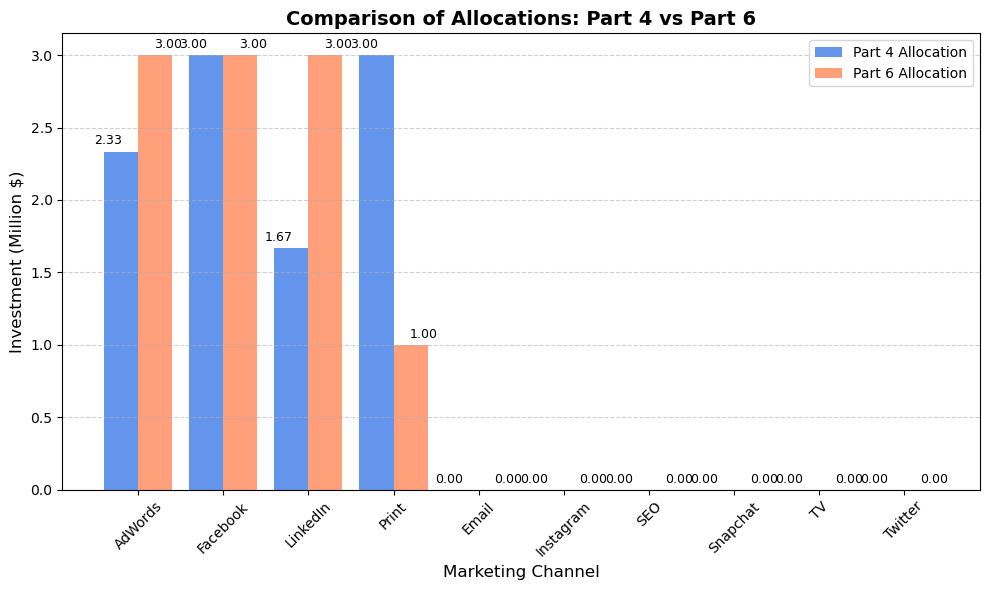

In [2]:
# --- Comparison Chart: Part 4 vs Part 6 Allocations ---
import matplotlib.pyplot as plt
import pandas as pd

# Data for both parts
data = {
    "Medium": ["AdWords", "Facebook", "LinkedIn", "Print", "Email", "Instagram", "SEO", "Snapchat", "TV", "Twitter"],
    "Part 4 Allocation (M$)": [2.333, 3.000, 1.667, 3.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000],
    "Part 6 Allocation (M$)": [3.000, 3.000, 3.000, 1.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]
}

df = pd.DataFrame(data)

# Plot setup
plt.figure(figsize=(10, 6))
x = range(len(df))

# Bars
plt.bar(x, df["Part 4 Allocation (M$)"], width=0.4, label="Part 4 Allocation", align="center", color="#6495ED")
plt.bar([i + 0.4 for i in x], df["Part 6 Allocation (M$)"], width=0.4, label="Part 6 Allocation", align="center", color="#FFA07A")

# Labels and formatting
plt.xticks([i + 0.2 for i in x], df["Medium"], rotation=45)
plt.xlabel("Marketing Channel", fontsize=12)
plt.ylabel("Investment (Million $)", fontsize=12)
plt.title("Comparison of Allocations: Part 4 vs Part 6", fontsize=14, fontweight='bold')
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.6)

# Annotate values
for i, v in enumerate(df["Part 4 Allocation (M$)"]):
    plt.text(i - 0.15, v + 0.05, f"{v:.2f}", ha="center", fontsize=9, color="black")

for i, v in enumerate(df["Part 6 Allocation (M$)"]):
    plt.text(i + 0.55, v + 0.05, f"{v:.2f}", ha="center", fontsize=9, color="black")

plt.tight_layout()
plt.show()
